In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import keras
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from sklearn.utils import shuffle
import time

import seaborn as sns
import dill     

Using TensorFlow backend.


In [2]:
filename = 'globalsave2.pkl'

In [ ]:
filename = 'globalsave20191808.pkl'
dill.dump_session(filename)

In [3]:
dill.load_session(filename)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [ ]:
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

## Réseau initial

Les données sont transformées pour être ensuite présentées au réseau.   
Une ligne du dataset est transformée en **matrice** à 3 dimensions (8,8,3)

- La première matrice représente le board en deux dimensions (8,8) vu du **joueur vertical**.  Les cases que le joueur peut -jouer sont 0 et les cases déjà jouées sont 1.
- La seconde matrice représente le board vu du **joueur horizontal**.  Les cases que le joueur peut jouer sont marquées 1 et les cases déjà jouées sont marquées 0.
- La troisième matrice est une matrice de 0 si le tour est pour le joueur vertical et 1 si le tour est pour le joueur horizontal.

L'output est une matrice nulle (8,8) sauf pour la position à jouer (la première des deux cases)

Nous entrainons un réseau de neurones convolutif 3D
- 1 couche d'entrée Conv2D-Relu avec un filtre (3,3) et 64 plans 
- 5 couches de convolution Conv2D-Relu cachées
- 1 dernière couche entièrement connectée (Fully Connected) à la sortie avec activation softmax car nous entrainons le réseau pour une classification multiclasses à un seul label(chacune des classes est une case à jouer sur le board)

In [36]:
callbacks_list = [ keras.callbacks.EarlyStopping( monitor='val_acc', patience=3, )]

In [37]:
def get_model(board_size):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(board_size, board_size, 3), padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Flatten())
    model.add(Dense(board_size**2, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model

def prepare_data(row, board_size):
    board = row[:board_size**2]
    flipped_board = row[board_size**2:2*board_size**2]
    turn = row[2*board_size**2:3*board_size**2]
    output = row[3*board_size**2:]
    
    board = np.array(board).reshape((board_size, board_size))
    flipped_board = np.array(flipped_board).reshape((board_size, board_size))
    turn = np.array(turn).reshape((board_size, board_size))
    output = np.array(output)

    state = np.zeros((board_size, board_size, 3))
    state[:,:,0] = board
    state[:,:,1] = flipped_board
    state[:,:,2] = turn

    return state, output



Les données sont lues du fichier csv et séparées en un ensemble d'entrainement (**70%**) et un ensemble de test (**30%**).

Nous prenons les dernières lignes pour le test.


In [38]:
filename = 'domineering.csv'
df = pd.read_csv(filename, sep=',', na_values=[""], header=None)
board_size = 8

df=shuffle(df)
data = df.values.tolist()
train = data[:int(0.7*len(data))]
test = data[int(0.7*len(data)):]

X = []

for t in train:
    row = prepare_data(t, board_size)
    X.append(row)

X_train = np.array([k[0] for k in X])
Y_train = np.array([k[1] for k in X])

XT = []

for t in test:
    row = prepare_data(t, board_size)
    XT.append(row)

X_test = np.array([k[0] for k in XT])
Y_test = np.array([k[1] for k in XT])

model = get_model(board_size)

Nous entrainons le réseau sur 20 époques avec un ensemble de valiation de 10% du Train

In [39]:
history=model.fit(X_train, Y_train, validation_split=0.1, epochs=20,#callbacks=callbacks_list
                 )

Train on 17737 samples, validate on 1971 samples
Epoch 1/20
17737/17737 [==============================] - 13s 751us/step - loss: 3.2563 - acc: 0.1806 - val_loss: 2.1669 - val_acc: 0.4485
Epoch 2/20
17737/17737 [==============================] - 5s 274us/step - loss: 1.8984 - acc: 0.4774 - val_loss: 1.8267 - val_acc: 0.4810
Epoch 3/20
17737/17737 [==============================] - 5s 275us/step - loss: 1.6791 - acc: 0.5162 - val_loss: 1.8228 - val_acc: 0.4957
Epoch 4/20
17737/17737 [==============================] - 5s 273us/step - loss: 1.5625 - acc: 0.5459 - val_loss: 1.7327 - val_acc: 0.4992
Epoch 5/20
17737/17737 [==============================] - 5s 272us/step - loss: 1.4640 - acc: 0.5685 - val_loss: 1.7564 - val_acc: 0.4911
Epoch 6/20
17737/17737 [==============================] - 5s 277us/step - loss: 1.3698 - acc: 0.5902 - val_loss: 1.8182 - val_acc: 0.4901
Epoch 7/20
17737/17737 [==============================] - 5s 272us/step - loss: 1.2638 - acc: 0.6237 - val_loss: 1.9405 - 

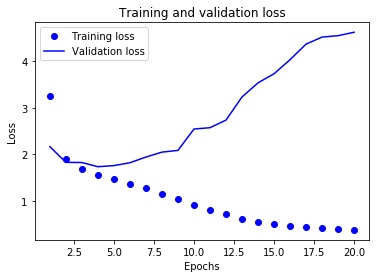

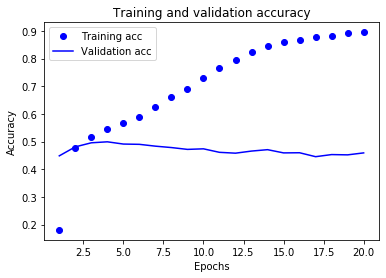

In [40]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf() #Clears the figure
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()    

plot_history(history)

Réentrainons le modèle avec le nombre d'époques qui minimise l'erreur sur l'ensemble de validation

In [41]:
model = get_model(board_size)
history=model.fit(X_train, Y_train, validation_split=0.1, epochs=5)
NN_initial_no_augmentation_17k = model

Train on 17737 samples, validate on 1971 samples
Epoch 1/5
17737/17737 [==============================] - 6s 336us/step - loss: 3.5094 - acc: 0.1202 - val_loss: 2.3372 - val_acc: 0.3983
Epoch 2/5
17737/17737 [==============================] - 5s 256us/step - loss: 1.9539 - acc: 0.4623 - val_loss: 1.8288 - val_acc: 0.4860
Epoch 3/5
17737/17737 [==============================] - 5s 260us/step - loss: 1.6987 - acc: 0.5128 - val_loss: 1.7652 - val_acc: 0.5063
Epoch 4/5
17737/17737 [==============================] - 5s 255us/step - loss: 1.5786 - acc: 0.5368 - val_loss: 1.8154 - val_acc: 0.4886
Epoch 5/5
17737/17737 [==============================] - 5s 256us/step - loss: 1.4839 - acc: 0.5622 - val_loss: 1.7867 - val_acc: 0.4911


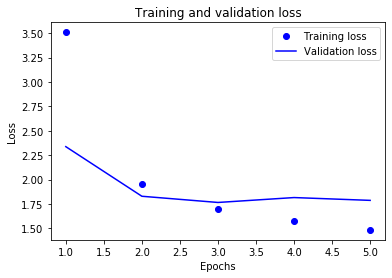

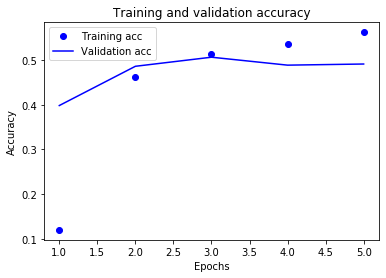

In [42]:
plot_history(history)

Nous pouvons alors faire les prédictions sur l'ensemble de test

In [43]:
pred_test = model.predict(X_test)
acc = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(pred_test, axis=1))
print("Accuracy : %s " %acc)

Accuracy : 0.4802888599502782 


Nous obtenons une accuracy sur le test à **0.493** 

## Data augmentation

Nous allons essayer d'améliorer ce score par une Data augmentation.

Nous utiliserons trois symétries:
- le board vu en **miroir**.  Nous utilsons la fonction prepare_data_lr qui retourne le board dans le sens gauche-droite
- le board vu de **bas en haut**.  Nous utilisons la fonction prepare_data_ud qui retourne le board de bas en haut.
- le board **tourné à 90**.  Nous utilisons la fonction prepare_data_90 qui fait une rotation à 90 du board.  Le joueur vertical devient horizontal et inversement

In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D


def prepare_data_lr(row, board_size):
    data = prepare_data(row, board_size)
    state = data[0]
    state = np.fliplr(state)
    
    output = data[1]
    output = np.array(output).reshape((board_size, board_size)) #on retourne l'output
    output = np.fliplr(output)

    player = int(state[:, :, 2][0][0])
    if player == 0:  # joueur vertical rien ne change pour l'output
        output = output.ravel()
        return state, output
    if player == 1:  # joueur horizental
        permutation = [7, 0, 1, 2, 3, 4, 5, 6] # le 1 se retrouve sur la dernière case à jouer on permute pour avoir la première case
        i = np.argsort(permutation)
        output_moved = output[:, i]
        output_moved = output_moved.ravel()
        return state, output_moved

def prepare_data_ud(row, board_size):
    data = prepare_data(row, board_size)
    state = data[0]
    state = np.flipud(state)

    output = data[1]
    output = np.array(output).reshape((board_size, board_size)) #on retourne l'output
    output = np.flipud(output)

    player = int(state[:, :, 2][0][0])
    if player == 1:  # horizental
        output = output
        output = output.ravel()
        return state, output
    if player == 0:  # vertical
        output_moved = np.roll(output, 7, axis=0) # on décale pour avoir l'output sur la première case à jouer 
        output_moved = output_moved.ravel()
        return state, output_moved

def prepare_data_90(row, board_size):
    data = prepare_data(row, board_size)
    state = data[0]
    state = np.rot90(state,-1)
    
    output = data[1]
    output = np.array(output).reshape((board_size, board_size))
    output = np.rot90(output,-1)

    player = int(state[:, :, 2][0][0])
    if player == 1:  # horizontal devient vertical
        var=state[:,:,1]
        state[:,:,1]=state[:,:,0]
        state[:,:,0]=var
        state[:,:,2]=0    
        output = output
        output = output.ravel()
        return state, output
    if player == 0:  # vertical devient horizontal
        var=state[:,:,0]
        state[:,:,0]=state[:,:,1]
        state[:,:,1]=var
        state[:,:,2]=1
        permutation = [7, 0, 1, 2, 3, 4, 5, 6] # le 1 se retrouve sur la dernière case à jouer on permute pour avoir la première case
        i = np.argsort(permutation)
        output_moved = output[:, i]
        output_moved = output_moved.ravel()
        return state, output_moved


filename = 'domineering.csv'
df = pd.read_csv(filename, sep=',', na_values=[""], header=None)
board_size = 8
df=shuffle(df)
data = df.values.tolist()
train = data[:int(0.7*len(data))]
test = data[int(0.7*len(data)):]

X = []

for t in train:
    row = prepare_data(t, board_size)
    X.append(row)
    row_lr = prepare_data_lr(t, board_size)
    X.append(row_lr)
    row_ud = prepare_data_ud(t, board_size)
    X.append(row_ud)
    row_90=prepare_data_90(t,board_size)
    X.append(row_90)

X_train = np.array([k[0] for k in X])
Y_train = np.array([k[1] for k in X])

XT = []

for t in test:
    row = prepare_data(t, board_size)
    XT.append(row)
    row_lr = prepare_data_lr(t, board_size)
    XT.append(row_lr)
    row_ud = prepare_data_ud(t, board_size)
    XT.append(row_ud)
    row_90=prepare_data_90(t,board_size)
    XT.append(row_90)


X_test = np.array([k[0] for k in XT])
Y_test = np.array([k[1] for k in XT])


XT=[]
for t in test:
    row = prepare_data(t, board_size)
    XT.append(row)
X_test_na = np.array([k[0] for k in XT])
Y_test_na = np.array([k[1] for k in XT])

model = get_model(board_size)

In [45]:
callbacks_list = [ keras.callbacks.EarlyStopping( monitor='val_acc', patience=3, )]
history=model.fit(X_train, Y_train, validation_split=0.1, epochs=20,batch_size=64,callbacks=callbacks_list)
NN_initial_with_augmentation_70k = history

Train on 70948 samples, validate on 7884 samples
Epoch 1/20
70948/70948 [==============================] - 11s 159us/step - loss: 2.7303 - acc: 0.2675 - val_loss: 2.0390 - val_acc: 0.4053
Epoch 2/20
70948/70948 [==============================] - 10s 135us/step - loss: 1.8260 - acc: 0.4532 - val_loss: 1.8772 - val_acc: 0.4277
Epoch 3/20
70948/70948 [==============================] - 10s 135us/step - loss: 1.7206 - acc: 0.4806 - val_loss: 1.8080 - val_acc: 0.4532
Epoch 4/20
70948/70948 [==============================] - 10s 134us/step - loss: 1.6543 - acc: 0.4995 - val_loss: 1.7900 - val_acc: 0.4592
Epoch 5/20
70948/70948 [==============================] - 10s 135us/step - loss: 1.5961 - acc: 0.5169 - val_loss: 1.8013 - val_acc: 0.4546
Epoch 6/20
70948/70948 [==============================] - 10s 136us/step - loss: 1.5425 - acc: 0.5330 - val_loss: 1.8489 - val_acc: 0.4551
Epoch 7/20
70948/70948 [==============================] - 10s 137us/step - loss: 1.4869 - acc: 0.5478 - val_loss: 1.8

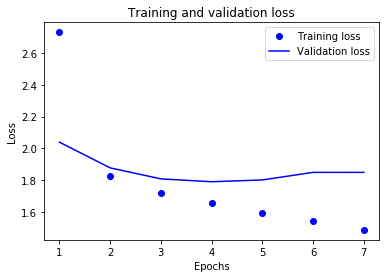

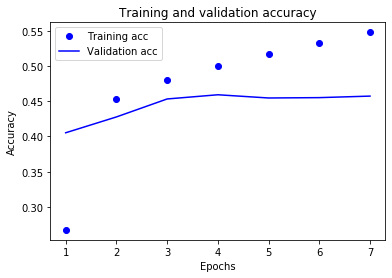

In [46]:
plot_history(history)

In [47]:
def accuracy_test(model,X_test,Y_test,X_test_na,Y_test_na):
    #Accuracy test augmenté
    pred_test = model.predict(X_test)
    acc = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(pred_test, axis=1))
    print("Accuracy Test augmenté: %s " %acc)
    
    #Accuracy test non augmenté
    
    pred_test = model.predict(X_test_na)
    acc = accuracy_score(np.argmax(Y_test_na, axis=1), np.argmax(pred_test, axis=1))
    print("Accuracy Test non augmenté: %s " %acc)    


In [48]:
accuracy_test(model,X_test,Y_test,X_test_na,Y_test_na)

Accuracy Test augmenté: 0.4555167515094116 
Accuracy Test non augmenté: 0.4412217355274062 


On va tenter un meilleur score avec une seule symétrie

## Data augmentation à 90

In [49]:
filename = 'domineering.csv'
df = pd.read_csv(filename, sep=',', na_values=[""], header=None)
board_size = 8
df=shuffle(df)
data = df.values.tolist()
train = data[:int(0.7*len(data))]
test = data[int(0.7*len(data)):]

X = []

for t in train:
    row = prepare_data(t, board_size)
    X.append(row)
    row_90=prepare_data_90(t,board_size)
    X.append(row_90)

X_train = np.array([k[0] for k in X])
Y_train = np.array([k[1] for k in X])

XT = []

for t in test:
    row = prepare_data(t, board_size)
    XT.append(row)
    row_90=prepare_data_90(t,board_size)
    XT.append(row_90)


X_test = np.array([k[0] for k in XT])
Y_test = np.array([k[1] for k in XT])

model = get_model(board_size)

In [50]:
callbacks_list = [ keras.callbacks.EarlyStopping( monitor='val_acc', patience=3, )]
history=model.fit(X_train, Y_train, validation_split=0.1, epochs=20,batch_size=64,callbacks=callbacks_list)


Train on 35474 samples, validate on 3942 samples
Epoch 1/20
35474/35474 [==============================] - 6s 180us/step - loss: 3.5004 - acc: 0.1178 - val_loss: 2.5808 - val_acc: 0.3057
Epoch 2/20
35474/35474 [==============================] - 5s 135us/step - loss: 1.9509 - acc: 0.4527 - val_loss: 1.8729 - val_acc: 0.4734
Epoch 3/20
35474/35474 [==============================] - 5s 136us/step - loss: 1.7155 - acc: 0.5025 - val_loss: 1.7527 - val_acc: 0.5038
Epoch 4/20
35474/35474 [==============================] - 5s 134us/step - loss: 1.6171 - acc: 0.5229 - val_loss: 1.7273 - val_acc: 0.5109
Epoch 5/20
35474/35474 [==============================] - 5s 137us/step - loss: 1.5413 - acc: 0.5449 - val_loss: 1.7581 - val_acc: 0.5101
Epoch 6/20
35474/35474 [==============================] - 5s 136us/step - loss: 1.4718 - acc: 0.5641 - val_loss: 1.7710 - val_acc: 0.5068
Epoch 7/20
35474/35474 [==============================] - 5s 135us/step - loss: 1.3996 - acc: 0.5821 - val_loss: 1.7795 - v

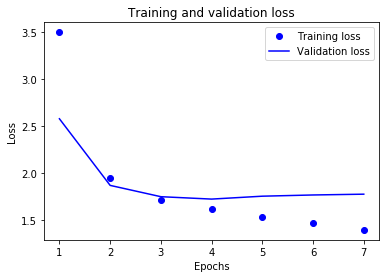

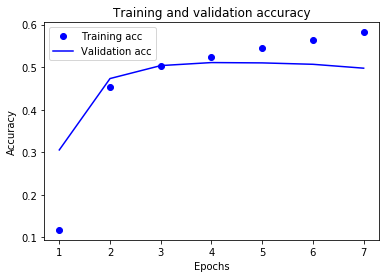

In [51]:
plot_history(history)

In [52]:
accuracy_test(model,X_test,Y_test,X_test_na,Y_test_na)

Accuracy Test augmenté: 0.4813543269799929 
Accuracy Test non augmenté: 0.5774831301053629 


## MaxPooling Dropout

Essayons d'introduire un subsampling par MaxPooling et une régularisation par Dropout 

In [53]:
from keras.layers import MaxPooling2D,Dropout
from keras import backend as K


def get_model2(board_size):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(board_size, board_size,3), padding="same",data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Dropout(0.3)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(0.3)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(0.3)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(board_size**2, activation='softmax'))    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model

In [54]:
filename = 'domineering.csv'
df = pd.read_csv(filename, sep=',', na_values=[""], header=None)
board_size = 8

data = df.values.tolist()
train = data[:int(0.7*len(data))]
test = data[int(0.7*len(data)):]

X = []

for t in train:
    row = prepare_data(t, board_size)
    X.append(row)
    row_90=prepare_data_90(t,board_size)
    X.append(row_90)

X_train = np.array([k[0] for k in X])
Y_train = np.array([k[1] for k in X])

XT = []

for t in test:
    row = prepare_data(t, board_size)
    XT.append(row)
    row_90=prepare_data_90(t,board_size)
    XT.append(row_90)


X_test = np.array([k[0] for k in XT])
Y_test = np.array([k[1] for k in XT])

model2 = get_model2(board_size)

In [55]:
history=model2.fit(X_train, Y_train, validation_split=0.1, epochs=20,batch_size=64,callbacks=callbacks_list)

Train on 35474 samples, validate on 3942 samples
Epoch 1/20
35474/35474 [==============================] - 8s 214us/step - loss: 3.9131 - acc: 0.0345 - val_loss: 3.8002 - val_acc: 0.0444
Epoch 2/20
35474/35474 [==============================] - 5s 149us/step - loss: 3.7429 - acc: 0.0527 - val_loss: 3.7040 - val_acc: 0.0568
Epoch 3/20
35474/35474 [==============================] - 5s 153us/step - loss: 3.6775 - acc: 0.0656 - val_loss: 3.5972 - val_acc: 0.0771
Epoch 4/20
35474/35474 [==============================] - 5s 150us/step - loss: 3.5372 - acc: 0.0989 - val_loss: 3.3407 - val_acc: 0.1613
Epoch 5/20
35474/35474 [==============================] - 5s 150us/step - loss: 3.2371 - acc: 0.1750 - val_loss: 2.9149 - val_acc: 0.2620
Epoch 6/20
35474/35474 [==============================] - 5s 152us/step - loss: 2.9394 - acc: 0.2603 - val_loss: 2.6447 - val_acc: 0.3529
Epoch 7/20
35474/35474 [==============================] - 5s 150us/step - loss: 2.7612 - acc: 0.3149 - val_loss: 2.4925 - v

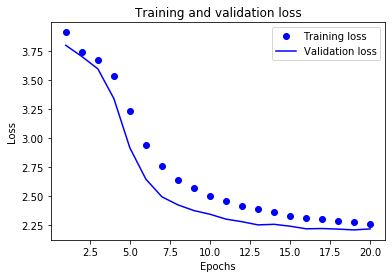

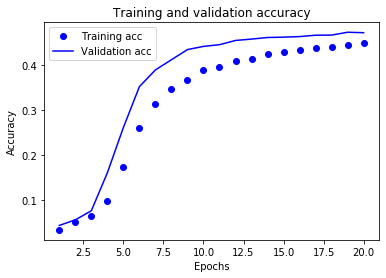

In [56]:
plot_history(history)

In [57]:
accuracy_test(model2,X_test,Y_test,X_test_na,Y_test_na)

Accuracy Test augmenté: 0.4768556884100864 
Accuracy Test non augmenté: 0.5085829288504795 


Supprimons le Max Pooling car on perd peut être l'information de la structure du jeu

In [58]:
from keras.layers import MaxPooling2D,Dropout
from keras import backend as K


def get_model3(board_size):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(board_size, board_size,3), padding="same",data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(0.3)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same")) 
    model.add(Dropout(0.3)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(0.3)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(0.3)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(board_size**2, activation='softmax'))    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model

In [59]:
filename = 'domineering.csv'
df = pd.read_csv(filename, sep=',', na_values=[""], header=None)
board_size = 8
df=shuffle(df)
data = df.values.tolist()
train = data[:int(0.7*len(data))]
test = data[int(0.7*len(data)):]

X = []

for t in train:
    row = prepare_data(t, board_size)
    X.append(row)
    row_90=prepare_data_90(t,board_size)
    X.append(row_90)
    
X_train = np.array([k[0] for k in X])
Y_train = np.array([k[1] for k in X])

XT = []

for t in test:
    row = prepare_data(t, board_size)
    XT.append(row)
    row_90=prepare_data_90(t,board_size)
    XT.append(row_90)

X_test = np.array([k[0] for k in XT])
Y_test = np.array([k[1] for k in XT])

model3 = get_model3(board_size)

In [60]:
history=model3.fit(X_train, Y_train, validation_split=0.1, epochs=20,batch_size=64,callbacks=callbacks_list)

Train on 35474 samples, validate on 3942 samples
Epoch 1/20
35474/35474 [==============================] - 7s 210us/step - loss: 3.8382 - acc: 0.0467 - val_loss: 3.6905 - val_acc: 0.0583
Epoch 2/20
35474/35474 [==============================] - 6s 155us/step - loss: 2.6674 - acc: 0.2911 - val_loss: 2.1071 - val_acc: 0.4239
Epoch 3/20
35474/35474 [==============================] - 5s 154us/step - loss: 2.0039 - acc: 0.4378 - val_loss: 1.8324 - val_acc: 0.4845
Epoch 4/20
35474/35474 [==============================] - 5s 153us/step - loss: 1.8658 - acc: 0.4709 - val_loss: 1.7907 - val_acc: 0.4866
Epoch 5/20
35474/35474 [==============================] - 6s 156us/step - loss: 1.7927 - acc: 0.4839 - val_loss: 1.7753 - val_acc: 0.4906
Epoch 6/20
35474/35474 [==============================] - 5s 153us/step - loss: 1.7384 - acc: 0.4967 - val_loss: 1.7576 - val_acc: 0.4911
Epoch 7/20
35474/35474 [==============================] - 5s 153us/step - loss: 1.6970 - acc: 0.5051 - val_loss: 1.7511 - v

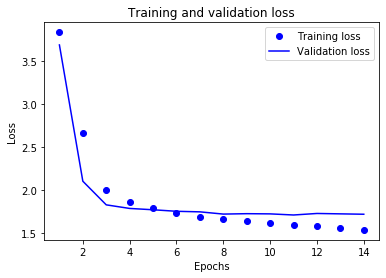

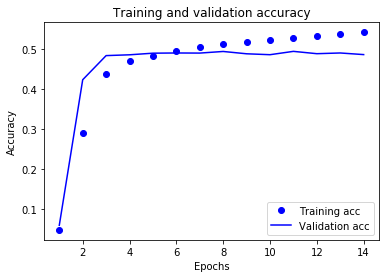

In [61]:
plot_history(history)

In [62]:
model3 = get_model3(board_size)
model3.fit(X_train, Y_train, validation_split=0.1, epochs=8,batch_size=64,callbacks=callbacks_list)

Train on 35474 samples, validate on 3942 samples
Epoch 1/8
35474/35474 [==============================] - 8s 216us/step - loss: 3.7811 - acc: 0.0548 - val_loss: 3.5778 - val_acc: 0.0921
Epoch 2/8
35474/35474 [==============================] - 5s 155us/step - loss: 2.4671 - acc: 0.3324 - val_loss: 1.9977 - val_acc: 0.4495
Epoch 3/8
35474/35474 [==============================] - 5s 154us/step - loss: 1.9823 - acc: 0.4436 - val_loss: 1.8503 - val_acc: 0.4739
Epoch 4/8
35474/35474 [==============================] - 5s 153us/step - loss: 1.8616 - acc: 0.4697 - val_loss: 1.7946 - val_acc: 0.4835
Epoch 5/8
35474/35474 [==============================] - 6s 156us/step - loss: 1.7947 - acc: 0.4819 - val_loss: 1.7774 - val_acc: 0.4779
Epoch 6/8
35474/35474 [==============================] - 5s 154us/step - loss: 1.7398 - acc: 0.4962 - val_loss: 1.8450 - val_acc: 0.4678
Epoch 7/8
35474/35474 [==============================] - 5s 155us/step - loss: 1.7006 - acc: 0.5047 - val_loss: 1.7431 - val_acc:

In [63]:
accuracy_test(model3,X_test,Y_test,X_test_na,Y_test_na)

Accuracy Test augmenté: 0.5061560317272404 
Accuracy Test non augmenté: 0.5425594885758257 


Essayons ce modèle sur le jeu augmenté des 3 symmétries

In [64]:
model3 = get_model3(board_size)
X = []

for t in train:
    row = prepare_data(t, board_size)
    X.append(row)
    row_lr = prepare_data_lr(t, board_size)
    X.append(row_lr)
    row_ud = prepare_data_ud(t, board_size)
    X.append(row_ud)
    row_90=prepare_data_90(t,board_size)
    X.append(row_90)
    
X_train = np.array([k[0] for k in X])
Y_train = np.array([k[1] for k in X])

XT = []

for t in test:
    row = prepare_data(t, board_size)
    XT.append(row)
    row_lr = prepare_data_lr(t, board_size)
    XT.append(row_lr)
    row_ud = prepare_data_ud(t, board_size)
    XT.append(row_ud)
    row_90=prepare_data_90(t,board_size)
    XT.append(row_90)

X_test = np.array([k[0] for k in XT])
Y_test = np.array([k[1] for k in XT])

history=model3.fit(X_train, Y_train, validation_split=0.1, epochs=20,callbacks=callbacks_list)

Train on 70948 samples, validate on 7884 samples
Epoch 1/20
70948/70948 [==============================] - 24s 332us/step - loss: 3.1164 - acc: 0.1850 - val_loss: 2.1193 - val_acc: 0.3853
Epoch 2/20
70948/70948 [==============================] - 21s 299us/step - loss: 2.0518 - acc: 0.3962 - val_loss: 1.8910 - val_acc: 0.4335
Epoch 3/20
70948/70948 [==============================] - 21s 302us/step - loss: 1.9188 - acc: 0.4307 - val_loss: 1.8193 - val_acc: 0.4463
Epoch 4/20
70948/70948 [==============================] - 21s 300us/step - loss: 1.8725 - acc: 0.4422 - val_loss: 1.7830 - val_acc: 0.4618
Epoch 5/20
70948/70948 [==============================] - 21s 302us/step - loss: 1.8393 - acc: 0.4518 - val_loss: 1.7815 - val_acc: 0.4585
Epoch 6/20
70948/70948 [==============================] - 21s 303us/step - loss: 1.8206 - acc: 0.4592 - val_loss: 1.7772 - val_acc: 0.4630
Epoch 7/20
70948/70948 [==============================] - 21s 302us/step - loss: 1.8102 - acc: 0.4590 - val_loss: 1.7

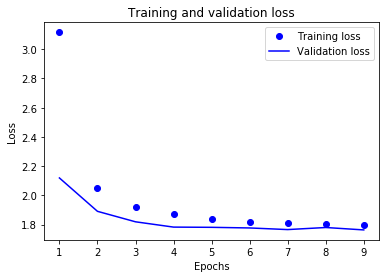

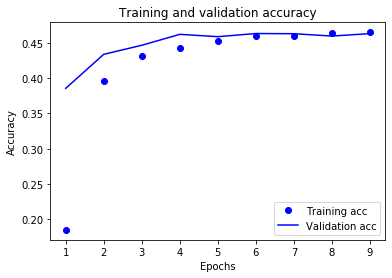

In [65]:
plot_history(history)

In [66]:
accuracy_test(model3,X_test,Y_test,X_test_na,Y_test_na)

Accuracy Test augmenté: 0.47297857227418016 
Accuracy Test non augmenté: 0.4833668758138984 


## Conclusion

Nous retenons le modèle sans MaxPooling avec Dropout (modèle 3) entrainé sur le jeu de données 
augmenté avec la symmétrie à 90 degrés.  C'est le réseau qui donne la meilleure accuracy à la fois sur le Test initial et le Test augmenté.  Le premier réseau donne également des résultats similaires mais sans Data Augmentation.

# PARTIE II - Jeux etc.

### Code pour jouer la partie

Nous tentons maintenant de faire jouer nous différents réseaux afin :
de les confronter aux règles de jeux, et voir si le réseau de prédit pas dénouer des coups qui ne serait pas possibles.
De tester si et comment l’accuracy se traduit en capacité de gagner le jeu.
…
Pour cela on commencer par tester le NN contre un bot jouant de façon aléatoire.

player = 1 : Horizontal (H)
player = 2 : Vertical (V)


Code pour jouer les parties standard :
- Évaluer les coups possibles 
- Choisir un coup à jouer (random ou par Monte Carlo)
- Jouer le coup, ie: mettre à jours le damier
- jouer une partie complète et retourner le vainqueur
Au global:
- Un bot random : qui joue aléatoirement
- un bot Monte Carlo (noté MC): qui va réaliser un nombre d'itération définit et tester des possibilités de jeux qui mennent à la victoire, le coup choisi pour etre joué est celui dont le nombres de victoire est le plus important dans les multiples chaines joués.


In [67]:
import random
from random import randint

def coup_H(A,i,j):
    if A[i,j] == 0 and A[i+1,j] == 0:
        A[i,j] = 1
        A[i+1,j] = 1
        
def coup_V(A,i,j):
    if A[i,j] == 0 and A[i,j+1] == 0:
        A[i,j] = 2
        A[i,j+1] = 2
        
def coups_possibles_H(A):
    liste_possible = []
    for i in range(0,len(A)-1):
        for j in range(0,len(A)):
            if A[i,j] ==0 and A[i+1,j] == 0:
                liste_possible.append((i,j))
    return liste_possible

def coups_possibles_V(A):
    liste_possible = []
    for i in range(0,len(A)):
        for j in range(0,len(A)-1):
            if A[i,j] ==0 and A[i,j+1] == 0:
                liste_possible.append((i,j))
    return liste_possible


def rand_domineering(A, player):
    while 1:
        if player == 1:
            if coups_possibles_H(A) != []:
                play = random.choice(coups_possibles_H(A))
                coup_H(A, play[0], play[1])
                player = 2
            else:
                return player
        if player == 2:
            if coups_possibles_V(A) != []:
                play = random.choice(coups_possibles_V(A))
                coup_V(A, play[0], play[1])
                player = 1
            else:
                return player

def mc_domineering(A, player,niter):
    while 1:
        if player == 1:
            if coups_possibles_H(A) != []:
                play = montecarlo(A, player,niter)
                coup_H(A, play[0], play[1])
                player = 2
            else:
                return player
        if player == 2:
            if coups_possibles_V(A) != []:
                play = montecarlo(A, player,niter)
                coup_V(A, play[0], play[1])
                player = 1
            else:
                return player


def montecarlo(A, player, niter) :
    B = np.copy(A)
    if player == 1:
        moves = coups_possibles_H(B)
        if moves != []:
            for coup in moves:
                victoire = np.zeros(len(moves))
                for i in range(0,niter):
                    coup_H(B, coup[0], coup[1])
                    loser = rand_domineering(B, 2)
                    if loser == 2:
                        victoire[moves.index(coup)] = victoire[moves.index(coup)] + 1
    if player == 2:
        moves = coups_possibles_V(B)
        if moves != []:
            for coup in moves:
                victoire = np.zeros(len(moves))
                for i in range(0,niter):
                    coup_V(B, coup[0], coup[1])
                    loser = rand_domineering(B, 1)
                    if loser == 1:
                        victoire[moves.index(coup)] = victoire[moves.index(coup)] + 1
    victoire = victoire / niter
    max = 0
    for i in range(0, len(victoire)):
        if victoire[i] > max:
            max = victoire[i]
            coupchoisi = moves[i]
    return coupchoisi


def rand_vs_mc_domineering(A, player,niter):
    while 1:
        if player == 1:
            if coups_possibles_H(A) != []:
                play = montecarlo(A, player,niter)
                coup_H(A, play[0], play[1])
                player = 2
            else:
                return player
        if player == 2:
            if coups_possibles_V(A) != []:
                play = random.choice(coups_possibles_V(A))
                coup_V(A, play[0], play[1])
                player = 1
            else:
                return player

**Faisont jouer ensemble les BOTs:**
- Random VS Ramdom
- Random VS MC
- MC VS MC


In [68]:
niter = 100 #itération de MC
ngame = 10 #nombres de parties

losers_Ran_VS_Ran = []
losers_Ran_VS_MC = []
losers_MC_VS_MC = []


for i in range(0,ngame):
    player = randint(1,2)
    damier = np.zeros((8, 8))
    losers_Ran_VS_Ran.append(rand_domineering(damier, player))

for i in range(0,ngame):
    player = randint(1,2)
    damier = np.zeros((8, 8))
    losers_MC_VS_MC.append(mc_domineering(damier, player,niter))

for i in range(0,ngame):
    player = randint(1,2)
    damier = np.zeros((8, 8))
    losers_Ran_VS_MC.append(rand_vs_mc_domineering(damier, player,niter))
 

    
print("Random VS Ramdom Joueur 1 perd (%):  ",100*np.count_nonzero( np.array(losers_Ran_VS_Ran) == 1)/ngame)

print("Random VS MC Joueur 1 perd (%): ",100*np.count_nonzero( np.array(losers_Ran_VS_MC) == 1)/ngame)

print("MC VS MC Joueur 1 perd (%): ",100*np.count_nonzero( np.array(losers_MC_VS_MC) == 1)/ngame)


Random VS Ramdom Joueur 1 perd (%):   70.0
Random VS MC Joueur 1 perd (%):  80.0
MC VS MC Joueur 1 perd (%):  100.0


Commentaire ...

## Partie joués avec les réseaux de neurones (NN) VS Bots

### Code spécifique pour jouer les parties 

Afin de pouvoir utiliser les réseaux que l'on a entrainés nous avons :
- Remettre le damier dans un format de données compatible (comme pour le train/test)
- Adapter le code, notamment pour éviter que le NN joue à des positions qu'il n’a pas de droit. En effet en faisant des tests on a remarqué que les réseaux tentent des coups qui ne sont pas possibles, notamment lorsque le damier commence à être beaucoup rempli

Nous avons choisi de tester les bots contre le réseau modèle3 :  sans MaxPooling avec Dropout et entrainé sur le jeu de données augmenté avec la symmétrie à 90 degrés

In [69]:
#remetre l'etat de jeu compréhensible par le NN
def f(a):
    if a>0:
        return 1
    return 0

def to_bool(xx):
    x = xx.ravel()
    return np.fromiter((f(xi) for xi in x), x.dtype).reshape(8,8)

def swap_player(xx):
    x = xx.ravel()
    return np.fromiter((np.where(xi==0,1,0) for xi in x), x.dtype).reshape(8,8)

def coup_NN(A,player,NN_name):
    state = np.zeros((1, 8, 8, 3)) 
    state[0,:,:,0] = to_bool(A)
    state[0,:,:,1] = swap_player(state[0,:,:,0])
    if player == 2 :
        state[0,:,:,2] = np.ones((8,8) ,dtype=np.int16)
    pos = np.argmax(NN_name.predict(state))
    return (pos // 8, pos % 8 )

### Réseau de neurone (NN) VS random bot

In [70]:
ngame = 2000

#jouer contre un bot random
def rand_VS_NN(A, player, NN_name):
    nb_bad = 0 
    while 1:
        if player == 1:
            if coups_possibles_H(A) != []:
               # print(A)
                play = coup_NN(A,player,NN_name)
               # print(play)
                if play[0] > 6:
                    play = random.choice(coups_possibles_H(A)) 
                    nb_bad = nb_bad + 1
                coup_H(A, play[0], play[1])
                player = 2
            else:
                return (player,nb_bad)
        if player == 2:
            if coups_possibles_V(A) != []:
                play = random.choice(coups_possibles_V(A))
                coup_V(A, play[0], play[1])
                player = 1
            else:
                return (player,nb_bad)
    

losers_ranNN = []


for i in range(0,ngame):
    player = randint(1,2)
    damier = np.zeros((8, 8))
    losers_ranNN.append(rand_VS_NN(damier, player,model3))

    
print("In Random Domineering, NN loses (%) : ",100*np.count_nonzero( np.array(losers_ranNN)[:,0] == 1)/ngame)
print(" En moyenne le NN tente de jouer XX coups impossibles par partie", sum (np.array(losers_ranNN)[:,1])/ngame)


In Random Domineering, NN loses (%) :  0.2
 En moyenne le NN tente de jouer XX coups impossibles par partie 0.0


On constate que:

- Le NN perd quand même quelques rares fois contre un bot qui joue aléatoirement (environ 0,2%)
- le NN tente également de jouer dans des positions qui ne font pas partie des coups possibles (dernières ligne ou colonnes, ou carrément à des endroits où il n'y a pas de place) : Ce phénomène est relativement dérangeant, car on n’a jamais appris au réseau à jouer de cette manière. Même si  l’acurracy est seulement de 0.5 on aura pu penser que le réseau avait « au moins » compris qu’il ne pouvait pas jouer dans les endroits déjà prie.

Afin de corriger ce, en cas de prédiction de coup impossible, on remplace encore une fois par un coup aléatoire.

On test maintenant contre un bot monte-carlo : ie un bot qui va tester plusieurs combinaison et ne retenir que les coup qui mènent à une victoire 

## NN VS MC

Le code est adapté pour faire jouer le NN ans les deux sens: vertival et horizontal. Cela permet de vérifier que le comportement est similaire dans ces deux cas.

In [71]:
def MC_VS_NN1(A, player, NN_name, niter):
    nb_bad = 0 
    while 1:
        if player == 1:
            cpH = coups_possibles_H(A)
            if cpH != []:
                play = coup_NN(A,player,NN_name)
                if (play not in cpH):
                    play = random.choice(cpH) 
                    nb_bad = nb_bad + 1
                coup_H(A, play[0], play[1])
                player = 2
            else:
                return (player,nb_bad)
        if player == 2:
            if coups_possibles_V(A) != []:
                play = montecarlo(A, player, niter)
                coup_V(A, play[0], play[1])
                player = 1
            else:
                return (player,nb_bad)
            
            
def MC_VS_NN2(A, player, NN_name, niter):
    nb_bad = 0 
    while 1:
        if player == 2:
            cpV = coups_possibles_V(A)
            if cpV != []:
                play = coup_NN(A,player,NN_name)
                if (play not in cpV):
                    play = random.choice(cpV) 
                    nb_bad = nb_bad + 1
                coup_V(A, play[0], play[1])
                player = 1
            else:
                return (player,nb_bad)
        if player == 1:
            if coups_possibles_H(A) != []:
                play = montecarlo(A, player, niter)
                coup_H(A, play[0], play[1])
                player = 2
            else:
                return (player,nb_bad)

In [72]:
ngame = 20
niter = 500 #pour MC

losers_MCNN1 = []


for i in range(0,ngame):
    player = randint(1,2)
    damier = np.zeros((8, 8))
    losers_MCNN1.append(MC_VS_NN1(damier, player,model3, niter))      
                 
print("In MC Domineering, NN (vertical) loses (%) : ",100*np.count_nonzero( np.array(losers_MCNN1)[:,0] == 1)/ngame)
print(" En moyenne le NN tente de jouer ", sum (np.array(losers_MCNN1)[:,1])/ngame , "  coups impossibles par partie")
    

losers_MCNN2 = []

for i in range(0,ngame):
    player = randint(1,2)
    damier = np.zeros((8, 8))
    losers_MCNN2.append(MC_VS_NN2(damier, player,model3, niter))      
            
print("In MC Domineering, NN (horizontal) loses (%) : ",100*np.count_nonzero( np.array(losers_MCNN2)[:,0] == 2)/ngame)
print(" En moyenne le NN tente de jouer ", sum (np.array(losers_MCNN2)[:,1])/ngame , "  coups impossibles par partie")

In MC Domineering, NN (vertical) loses (%) :  50.0
 En moyenne le NN tente de jouer  0.0   coups impossibles par partie
In MC Domineering, NN (horizontal) loses (%) :  0.0
 En moyenne le NN tente de jouer  0.0   coups impossibles par partie


**Constats de NN VS MC :**
- le réseau bat systématiquement le bot MC, peu importe la position de jeux
- Même en augmentant le nombre d’itérations de MC, le NN gagne toujours.

Le réseau a été entrainé à l’aide d’un jeu de données issues de parties jouées avec du Monte-Carlo (pour trouver le meilleur coup à jouer). Mais nous n’avons pas exactement plus de détail sur le données.
Le fait que le réseau soit toujours meilleur laisse penser que :

- les coups du jeu d’entrainement sont de « bonnes qualités » , c.-à-d. générées avec beaucoup  d’itération de Monte-Carlo. Et donc peu être qu’en augmentant beaucoup niter on aurait un bot MC gagnant. Nous avons testé jusqu’ à 500 itérations, sans succès. 


### Remarque : NN VS Bots

- Le NN gagne toutes les parties lorsqu'il joue contre des bot MC 
- le NN perds quelques parties lorsqu'il joue contre des bot aléatoire, il tente également des coups interdit

Cela illustre bien le défaut connu des NN à gérer des situations nouvelles pour lequel il n’a pas été entrainé (car le jeu d’entrainement est issu de simulation de Monte Carlo). 



## Affrontement entre les NN et réutilisation des coups gagnants

Dans cette partie on va faire jouer plusieurs NN les uns contre les autres afin de :

- Comprendre quelle structure de réseau est plus performante
- Voir comment l'accuracy et le fait de gagner les parties sont liés (ou pas)
- Réutiliser les historiques des parties pour augmenter le train

*le code suivant sert à jouer des parties NN VS NN ou NN VS MC en conservant les coups joués par le vainqueur*

In [73]:
#pour chaque coups retourne l'etat du board en format NN et la position choisi par le Réseau
def ReturnPlayForHist(A,player,NN_name, play):
    state = np.zeros((1, 8, 8, 3)) 
    state[0,:,:,0] = to_bool(A)
    state[0,:,:,1] = swap_player(state[0,:,:,0])
    if player == 2 :
        state[0,:,:,2] = np.ones((8,8) ,dtype=np.int16)
    pos =  play[0] + 8*play[1]
    pos_v = np.zeros(64)
    pos_v[pos] = 1
    return (state[0,:,:,0],state[0,:,:,1],state[0,:,:,2],pos_v)
           
#Meme fonction que précédement mais retroune égalemement l'historique (du vainqueur)

def MC_VS_NN1_histo(A, player, NN_name, niter,name):
    nb_bad = 0
    Historique1 = []
    Historique2 = []
    while 1:
        if player == 1:
            cpH = coups_possibles_H(A)
            if cpH != []:
                play = coup_NN(A,player,NN_name)
                if (play not in cpH):
                    play = random.choice(cpH) 
                    nb_bad = nb_bad + 1
                Historique1.append(ReturnPlayForHist(A,player,NN_name,play))
                coup_H(A, play[0], play[1])
                player = 2
            else:
               # print(PassHisto)
                return (name,nb_bad),Historique2
        if player == 2:
            if coups_possibles_V(A) != []:
                play = montecarlo(A, player, niter)
                Historique2.append(ReturnPlayForHist(A,player,"MC_Algo",play))
                coup_V(A, play[0], play[1])
                player = 1
            else:
                PassHisto = Historique1
                #print(PassHisto)
                return ("MC_Algo",nb_bad),Historique1

def MC_VS_NN2_histo(A, player, NN_name, niter,name):
    nb_bad = 0
    Historique1 = []
    Historique2 = []
    while 1:
        if player == 2:
            cpV = coups_possibles_V(A)
            if cpV != []:
                play = coup_NN(A,player,NN_name)
                if (play not in cpV):
                    play = random.choice(cpV) 
                    nb_bad = nb_bad + 1
                Historique1.append(ReturnPlayForHist(A,player,NN_name,play))
                coup_V(A, play[0], play[1])
                player = 1
            else:
                return (name,nb_bad),Historique2
        if player == 1:
            if coups_possibles_H(A) != []:
                play = montecarlo(A, player, niter)
                Historique2.append(ReturnPlayForHist(A,player,"MC_Algo",play))
                coup_H(A, play[0], play[1])
                player = 2
            else:
                return ("MC_Algo",nb_bad),Historique1            
            
            
def NN_VS_NN(A, player, NN_name1, NN_name2, NN_name1STR, NN_name2STR):
    nb_bad = 0
    Historique1 = []
    Historique2 = []
    while 1:
        if player == 1:
            cpH = coups_possibles_H(A)
            if cpH != []:
                play = coup_NN(A,player,NN_name1)
                if (play not in cpH):
                    play = random.choice(cpH) 
                    nb_bad = nb_bad + 1
                Historique1.append(ReturnPlayForHist(A,player,NN_name1,play))
                coup_H(A, play[0], play[1])
                player = 2
            else:
                return (NN_name1STR,nb_bad),Historique2
        if player == 2:
            cpV = coups_possibles_V(A)
            if cpV != []:
                play = coup_NN(A,player,NN_name2)
                if (play not in cpV):
                    play = random.choice(cpV) 
                    nb_bad = nb_bad + 1
                Historique2.append(ReturnPlayForHist(A,player,NN_name2,play))
                coup_V(A, play[0], play[1])
                player = 1
            else:
                return (NN_name2STR,nb_bad),Historique1
            

## Choix de l'architecture des réseaux 

**le code suivant sert à jouer des parties NN VS NN ou NN VS MC en conservant les coups joués par le vainqueur**

nous avons remis le code des modèles déjà détaillés en partie I (pour plus de lisibilité)

Les modèles utilisés pour la suite seront :
- le modèle de base : 6 couches denses Conv2D
- le modèle dropout_01: idem avec un dropout sur chaque couche de 0.1
- le modèle dropout_03: idem avec un dropout sur chaque couche de 0.3
- le modèle dropout_L: idem avec un dropout variable de 0.1 en entrée et 0.3 en sortie par pas de 0.05

Ces 4 modèles sont entrainés :

- une fois **sans** Data Augmentation (DA)
- une fois **avec** DA

Soit 8 réseaux au total


In [74]:
# liste des modèles:
cstboard_size = 8

def get_model_base(board_size = cstboard_size):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(board_size, board_size, 3), padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Flatten())
    model.add(Dense(board_size**2, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model

def get_model_dropout_01(board_size = cstboard_size):
    model = Sequential()
    droprate = .1
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(board_size, board_size,3), padding="same",data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(droprate)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same")) 
    model.add(Dropout(droprate)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(droprate)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(droprate)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(droprate))
    model.add(Flatten())
    model.add(Dense(board_size**2, activation='softmax'))    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model

def get_model_dropout_03(board_size = cstboard_size):
    model = Sequential()
    droprate = .3
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(board_size, board_size,3), padding="same",data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(droprate)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same")) 
    model.add(Dropout(droprate)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(droprate)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(droprate)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(droprate))
    model.add(Flatten())
    model.add(Dense(board_size**2, activation='softmax'))    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model


def get_model_dropout_L(board_size = cstboard_size):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(board_size, board_size,3), padding="same",data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(.1)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same")) 
    model.add(Dropout(.15)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(.2)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(.25)) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Dropout(.3))
    model.add(Flatten())
    model.add(Dense(board_size**2, activation='softmax'))    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model

Pour plus de lisibilité le code pour la préparation des données et la data Augmentation est remis ici.
Il servira également à traiter les données issues des historiques.

**Nous avons choisi ici de ne pas augmenter les données pour le test, notamment car nous voulons tester les réseaux sur une base commune et donc avec un train sans DA pour tous**


In [75]:
#augmenter le train
train_aug = False


#fichier original
filename = 'domineering.csv'
df = pd.read_csv(filename, sep=',', na_values=[""], header=None)
board_size = 8
df=shuffle(df)
data = df.values.tolist()
train = data[:int(0.7*len(data))]
test = data[int(0.7*len(data)):]

#train / test standard (no data augment)

def prepare_train_DA_NO(train,test):
    X = []

    for t in train:
        row = prepare_data(t, board_size)
        X.append(row)

    X_train_DA_NO = np.array([k[0] for k in X])
    Y_train_DA_NO = np.array([k[1] for k in X])

    XT = []

    for t in test:
        row = prepare_data(t, board_size)
        XT.append(row)

    X_test_DA_NO = np.array([k[0] for k in XT])
    Y_test_DA_NO = np.array([k[1] for k in XT])
    
    return X_train_DA_NO,Y_train_DA_NO,X_test_DA_NO,Y_test_DA_NO


#train / test augmented (yes data augment)
def prepare_train_DA_YES(train,test):
    X = []

    for t in train:
        row = prepare_data(t, board_size)
        X.append(row)
        row_lr = prepare_data_lr(t, board_size)
        X.append(row_lr)
        row_ud = prepare_data_ud(t, board_size)
        X.append(row_ud)
        row_90=prepare_data_90(t,board_size)
        X.append(row_90)

    X_train_DA_YES = np.array([k[0] for k in X])
    Y_train_DA_YES = np.array([k[1] for k in X])

    XT = []

    for t in test:
        row = prepare_data(t, board_size)
        XT.append(row)
        if train_aug:
            row_lr = prepare_data_lr(t, board_size)
            XT.append(row_lr)
            row_ud = prepare_data_ud(t, board_size)
            XT.append(row_ud)
            row_90=prepare_data_90(t,board_size)
            XT.append(row_90)


    X_test_DA_YES = np.array([k[0] for k in XT])
    Y_test_DA_YES = np.array([k[1] for k in XT])
    
    return X_train_DA_YES,Y_train_DA_YES,X_test_DA_YES,Y_test_DA_YES

def formathisto(HistoBrut):
    return np.concatenate((HistoBrut[1][1][0].ravel(),HistoBrut[1][1][1].ravel(),HistoBrut[1][1][2].ravel(),HistoBrut[1][1][3].ravel()),axis=0)

In [76]:
X_train_DA_NO,Y_train_DA_NO,X_test_DA_NO,Y_test_DA_NO =  prepare_train_DA_NO(train,test)
X_train_DA_YES,Y_train_DA_YES,X_test_DA_YES,Y_test_DA_YES =  prepare_train_DA_YES(train,test)


- Génération des données de train et test
- Chargement des modèles définis précédemment dans une liste dans une liste 

In [77]:
Model_list = []
Name_list = ["base","base_drop_01","base_drop_03","base_drop_L","baseDA","base_drop_01DA","base_drop_03DA","base_drop_LDA" ]
Model_list.append(get_model_base())
Model_list.append(get_model_dropout_01())
Model_list.append(get_model_dropout_03())
Model_list.append(get_model_dropout_L())
Model_list.append(get_model_base())
Model_list.append(get_model_dropout_01())
Model_list.append(get_model_dropout_03())
Model_list.append(get_model_dropout_L())


In [78]:
def Keras_training(Model,X_train,Y_train):
    callbacks_list = [ keras.callbacks.EarlyStopping( monitor='val_acc', patience=3 )]
    history=Model.fit(X_train, Y_train, validation_split=0.1, epochs=20,batch_size=128,callbacks=callbacks_list)
    return history

Keras_training : 

- Pour arrêter automatiquement l’entrainement, ici on choit 3 epoch 
- Le nombre d’unités de calcul disponible sur la carte graphique permet de réduire le temps de calcul en augmentant le batch size. On ne préfère cependant pas trop l’augmenter pour garder une certaine cohérence dans l’apprentissage (de position précise…)


In [79]:
Historique_all = []
t = time.process_time()
Historique_all.append(Keras_training(Model_list[0],X_train_DA_NO,Y_train_DA_NO))
Historique_all.append(Keras_training(Model_list[1],X_train_DA_NO,Y_train_DA_NO))
Historique_all.append(Keras_training(Model_list[2],X_train_DA_NO,Y_train_DA_NO))
Historique_all.append(Keras_training(Model_list[3],X_train_DA_NO,Y_train_DA_NO))
Historique_all.append(Keras_training(Model_list[4],X_train_DA_YES,Y_train_DA_YES))
Historique_all.append(Keras_training(Model_list[5],X_train_DA_YES,Y_train_DA_YES))
Historique_all.append(Keras_training(Model_list[6],X_train_DA_YES,Y_train_DA_YES))
Historique_all.append(Keras_training(Model_list[7],X_train_DA_YES,Y_train_DA_YES))
end = time.time()
elapsed_time = time.process_time() - t
print(elapsed_time) #660sec with batch = 64 ; 430sec with batch = 128

Train on 17737 samples, validate on 1971 samples
Epoch 1/20
17737/17737 [==============================] - 4s 243us/step - loss: 3.8532 - acc: 0.0514 - val_loss: 3.6898 - val_acc: 0.0604
Epoch 2/20
17737/17737 [==============================] - 1s 78us/step - loss: 3.1957 - acc: 0.1747 - val_loss: 2.4978 - val_acc: 0.3420
Epoch 3/20
17737/17737 [==============================] - 1s 78us/step - loss: 2.0370 - acc: 0.4469 - val_loss: 1.9467 - val_acc: 0.4698
Epoch 4/20
17737/17737 [==============================] - 1s 76us/step - loss: 1.7694 - acc: 0.5024 - val_loss: 1.8729 - val_acc: 0.4718
Epoch 5/20
17737/17737 [==============================] - 1s 76us/step - loss: 1.6412 - acc: 0.5243 - val_loss: 1.8295 - val_acc: 0.4749
Epoch 6/20
17737/17737 [==============================] - 1s 76us/step - loss: 1.5500 - acc: 0.5483 - val_loss: 1.8252 - val_acc: 0.4805
Epoch 7/20
17737/17737 [==============================] - 1s 76us/step - loss: 1.4668 - acc: 0.5675 - val_loss: 1.8421 - val_acc

**Commentaire sur l’apprentissage :**

Pour les modèles sans DA :

- Les modèles sans dropout sont plus rapides à entrainer : 8 Epoch pour base, 10 Epoch pour dropout_01, 12 Epoch pour dropout_03. 
- Étrangement le dropout_L (avec un dropout cumulé inférieur à dropout_03) met 13 Epoch (donc plus que dropout_03)

Pour les modèles avec DA (4 fois plus d’exemples) :

- le modèle de base met plus d’ Epoch (11) que sans DA, bien que le nombre d’exemples soit 4 fois plus important
- le modèle dropout_01 met seulement 8 Epoch à s’entrainer, c’est moins que sans DA. Peut être que ce taux de drop produit des effets intéressants sur le réseau (pour le type de problématique que nous avons ici)
- Le dropout_03 met plus d’Epoch à l’entrainer
- Le dropout_L met le même nombre d’Epoch (c’est le seul qui n’a pas bougé)


**Visualisation de l'accuracy sur le test :**

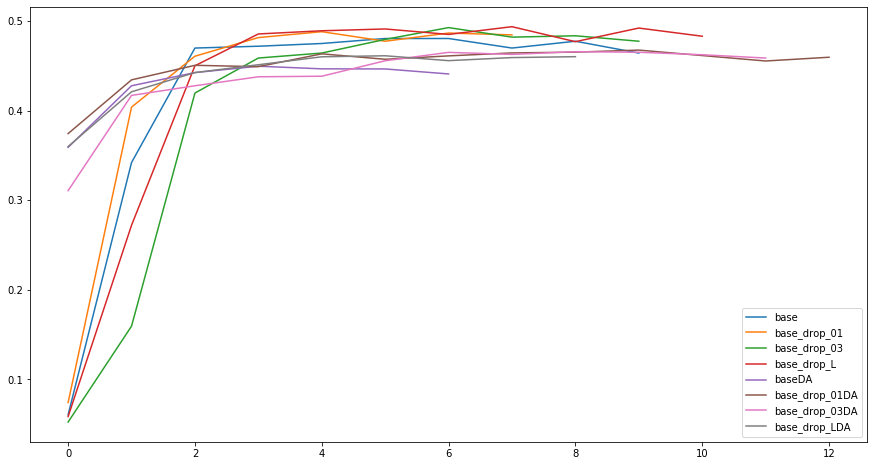

In [80]:
labels = []
plt.figure(figsize=(15,8))
for i in np.arange(0,len(Historique_all)):
    plt.plot(np.arange(0,len(Historique_all[i].history["val_acc"])), Historique_all[i].history["val_acc"])
    
plt.legend(np.array(Name_list))

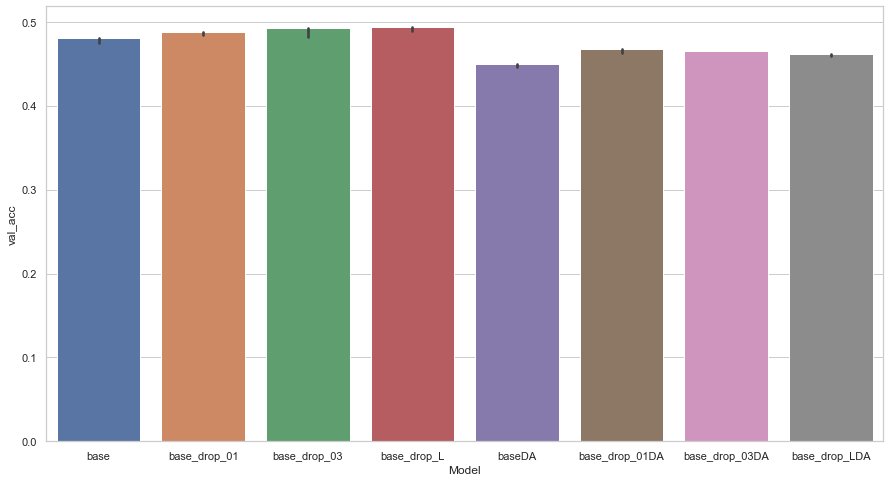

In [81]:
for i in np.arange(0,len(Historique_all)):
    if i == 0:
        df_data = pd.DataFrame(data = Historique_all[i].history)
        df_data["Model"] = Name_list[i]
    else:
        df_datatmp = pd.DataFrame(data = Historique_all[i].history)
        df_datatmp["Model"] = Name_list[i]
        df_data = pd.concat([df_data,df_datatmp])

sns.set(style="whitegrid")
plt.figure(figsize=(15,8))
sns.barplot(x="Model", y="val_acc", data=df_data , estimator= max)

**Commentaire sur les graphiques de "Val_acc" (acuracy sur le test):**

Systématiquement l’accuracy des réseaux entrainés sans DA est meilleur. 
### ARI : merci de trouver une explication plausible hahah…
Nous pensons que cela vient de la structure des données : les exemples du CSV blabla 


## Simulations des parties entres NN

### Etape 0 : test de tous les NN contre des bots MC

Pour avoir plus d’info sur la performance et le comportement des réseaux on commence par le faire jouer chacun contre un bot Monte-Carlo.

In [82]:
n_game = 100
niter = 100

Loser_badmove_MC = []
HistoWinner_MC = []
Histo_quel_NN_MC = []

for m in np.arange(0,len(Model_list)):
    for i in np.arange(0,n_game):
        damier = np.zeros((8, 8))
        player = randint(1,2)
        sens = randint(0,1)
        if sens == 0:
            x,y = MC_VS_NN2_histo(damier, player, Model_list[m], niter, Name_list[m])
        else :
            x,y = MC_VS_NN1_histo(damier, player, Model_list[m], niter, Name_list[m])  
        Loser_badmove_MC.append(x)
        HistoWinner_MC.append(y)
        Histo_quel_NN_MC.append(Name_list[m])
    print(Name_list[m])

base
base_drop_01
base_drop_03
base_drop_L
baseDA
base_drop_01DA
base_drop_03DA
base_drop_LDA


(800, 1)


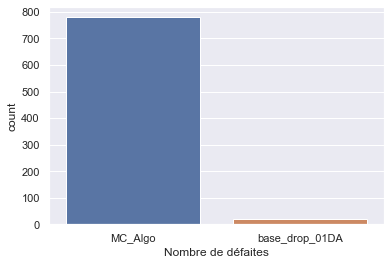

In [83]:
H01 = pd.DataFrame(np.array(Loser_badmove_MC)[:,0] , columns = ["Nombre de défaites"])
print(H01.shape)
sns.set(style = "darkgrid")
sns.countplot(x = "Nombre de défaites",data = H01)

le MC perds quasiment toutes se 
le MC gagne quelques parties contre le NN avec un dropout de 0.3 et la Data augmentation... c est assez bizzare, on verifira en réentrainant

In [84]:
d = {"BadMove" : np.array(Loser_badmove_MC)[:,1].astype("int32"), "NomNN":np.array(Histo_quel_NN_MC)  }
checkbad = pd.DataFrame(d)
#plt.figure(figsize=(20,10))
#ax = sns.barplot(x="NomNN", y="BadMove", data=checkbad)
print(np.sum(checkbad.iloc[:,0]))
checkbad.shape

0


(800, 2)

Les NN ne tentent pas de coups interdits quand ils jouent contre des bot MC (contrairement à precedement contre le bot random)

### Etape 1 :  Faire jouer chaque réseau contre lui même


Afin de contrôler les algorithmes et le comportement des NN on fait maintenant se battre le même réseau contre lui-même :
- Pour rappel nous avons un double aléa sur l'initialisation des parties (sur qui commence et sur sa position de jeu)
- Chaques réseau devrat avoir 50% de probabilité de gagner contre lui même (comme le jeux est equilibré)

Pour vérifier cela, les réseaux sont labélisés H et V selon qu’ils jouent verticalement ou horizontalement. Les réseaux notés ainsi se battent contre eux-mêmes. 

In [85]:
n_game = 100
niter = 100

Loser_badmove_Same_NN = []
HistoWinner_Same_NN = []
Histo_quel_NN_Same_NN = []

for m0 in np.arange(0,len(Model_list)):
    m1=m0
    for i in np.arange(0,n_game):
        damier = np.zeros((8, 8)) 
        player = randint(1,2)
        sens = randint(0,1)
        if sens == 0:
            x,y =  NN_VS_NN(damier, player, Model_list[m0] , Model_list[m1],(Name_list[m0]+"V"),(Name_list[m1]+"H"))
        else:
            x,y = NN_VS_NN(damier, player, Model_list[m1] , Model_list[m0],(Name_list[m1]+"V"),(Name_list[m0]+"H"))
        Loser_badmove_Same_NN.append(x)
        HistoWinner_Same_NN.append(y)
        Histo_quel_NN_Same_NN.append((Name_list[m0],Name_list[m1],x[0]))                          



*Visualisation du nombre de défaites des NN:*

In [86]:
def graph_bar_defaites(Histo):
    H02 = pd.DataFrame(np.array(Histo)[:,2] , columns = ["Réseau"])
    plt.figure(figsize=(12,8))
    H02["% de defaites"] = 1
    df_defaite_solo_G1 = 100*pd.pivot_table(H02, index = ["Réseau"], values = ["% de defaites"], aggfunc = np.sum )/(n_game)
    df_defaite_solo_G1.sort_values(["Réseau"]).plot.bar()

In [87]:
H02 = pd.DataFrame(np.array(Histo_quel_NN_Same_NN)[:,2] , columns = ["Réseau"])
H02.shape

(800, 1)

<Figure size 864x576 with 0 Axes>

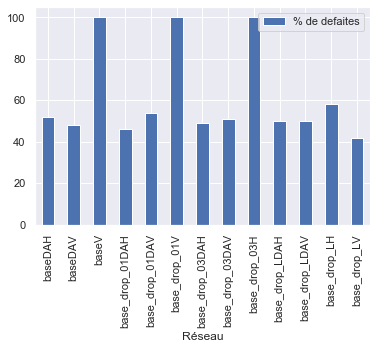

In [88]:
graph_bar_defaites(Histo_quel_NN_Same_NN)

**Étrangement, l’on constate que certains réseaux lorsqu’ ils jouent contre eux-mêmes ont deux sortes de comportements :**

- Un nombre de défaites relativement équivalent pour le réseau jouant V et celui jouant H : Le réseau jouant contre lui-même est aussi performant dans les deux sens de jeux (count = +/- 50)

- Toutes les défaites uniquement dans le même sens de jeux : Le réseau jouant contre lui-même perd systématiquement dans un sens (count = 100).

**De plus si l’on ré entraine les réseaux (avec les mêmes données), ce ne sont pas les mêmes modèles de NN qui jouent de façon déséquilibrée. Ainsi cela semble mettre en évidence que les conditions d’initialisation des réseaux et l’ordre des exemples ont une influence sur le comportement du réseau.**


### Etape 3 :  Faire jouer chaque réseau contre les autres reseaux

In [89]:
n_game = 200

Loser_badmove_NN_VS_NN = []
HistoWinner_NN_VS_NN = []
Histo_quel_NN_NN_VS_NN = []

for m0 in np.arange(0,len(Model_list)): 
    for m1 in np.arange(0,len(Model_list)):
        if m0 != m1:
            for i in np.arange(0,n_game):
                damier = np.zeros((8, 8)) #tester avec des etats aléatoirs apres
                player = randint(1,2)
                sens = randint(0,1)
                if sens == 0:
                    a,b = (Name_list[m0]),(Name_list[m1])
                    x,y =  NN_VS_NN(damier, player, Model_list[m0] , Model_list[m1],a,b)
                else:
                    b,a = (Name_list[m1]),(Name_list[m0])
                    x,y = NN_VS_NN(damier, player, Model_list[m1] , Model_list[m0],b,a)
                Loser_badmove_NN_VS_NN.append(x)
                HistoWinner_NN_VS_NN.append(y)
                Histo_quel_NN_NN_VS_NN.append((a,b,x[0]))
    print(m0, "/",len(Model_list)-1)

0 / 7
1 / 7
2 / 7
3 / 7
4 / 7
5 / 7
6 / 7
7 / 7


<Figure size 864x576 with 0 Axes>

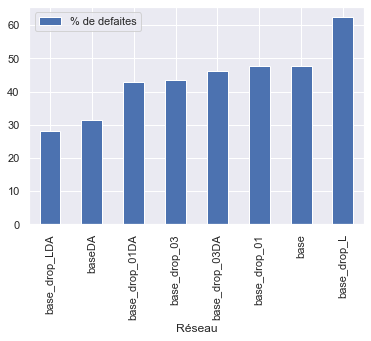

In [90]:
H03 = pd.DataFrame(np.array(Histo_quel_NN_NN_VS_NN)[:,2] , columns = ["Réseau"])
plt.figure(figsize=(12,8))
H03["% de defaites"] = 1
df_defaite_G1 = 100*pd.pivot_table(H03, index = ["Réseau"], values = ["% de defaites"], aggfunc = np.sum )/(len(Model_list)*2*n_game)
df_defaite_G1.sort_values(["% de defaites"]).plot.bar()

**En faisant jouer les NN contre les autres NN :**
- Les NN avec Data Augmentation (DA) ont le moins de défaites : entre 30 et 40%
- Les NN sans DA font environ 50% de défaites, sauf pour le NN de base avec 60%

Le fait que réseaux fassent presque exactement 50% de défaites est surprenants : cela laisse penser que les conditions de début de partie ont une influence sur les résultats. On creuse cette idée dans regardant les scores entre chaque NN.


In [91]:
def graph_2DWinners(Histo_quel_NN_NN_VS_NN):
    df_result = pd.DataFrame(data= Histo_quel_NN_NN_VS_NN , columns = ["player_1","player_2","Looser" ] )
    df_result["P1_win"] = (df_result["player_2"] == df_result["Looser"]).astype("int16")
    df_result["P2_win"] = (df_result["player_1"] == df_result["Looser"]).astype("int16")
    df_result_game = pd.pivot_table(df_result, "P1_win" , "player_1" , "player_2")
    plt.figure(figsize=(12,8), dpi= 80)
    sns.heatmap(df_result_game, xticklabels=Name_list, yticklabels=Name_list, cmap='RdYlGn', center=0, annot=True)
    plt.title('Taux de victoires par affrontement entre NN', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

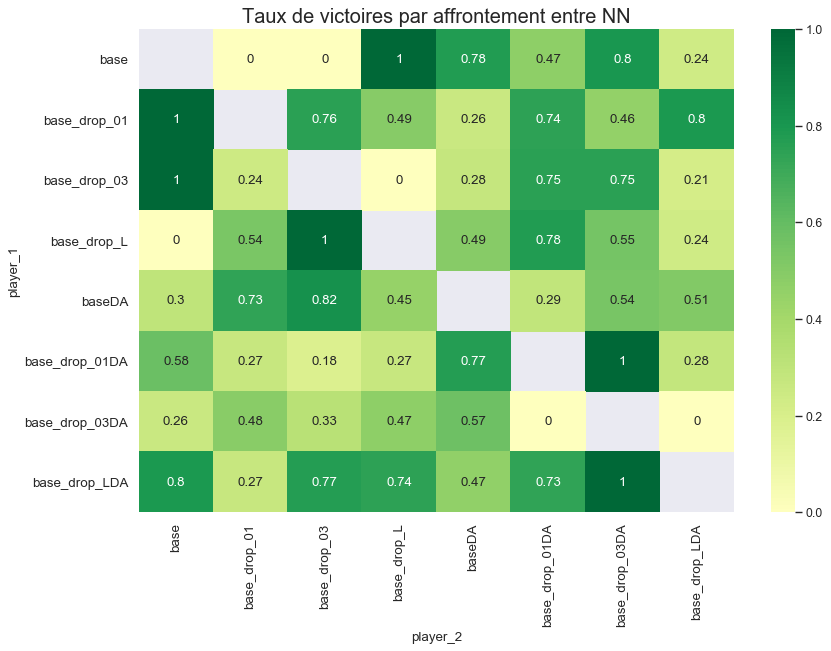

In [92]:
graph_2DWinners(Histo_quel_NN_NN_VS_NN)

**Les match entre les NN sont représentés sous la forme d'une matrice 2D, les lignes correspondent aux taux de victoires des NN contres les NN en colonnes**

## Configuration des parties 
- Chaque réseau de nombreuses parties contre chaque autres réseaux .
- Les prédictions des NN sont déterministes une fois le réseau entrainé, il jouera toujours pareil selon l'état du board. 
- Cela va aussi pour le premier coup de la partie et donc tous les coups suivants et pour toute la partie. l'état initiale du board erst donc déterminant sur la suite de la partie

Ainsi comme nous avons un double aléa sur le début de partie : sur la position de jeux et sur qui joue en premier. On observe donc, à un petit aléa pres, que les NN gagnent à 0%, 25%, 50%, 75% ou 100% contre les autres réseaux. Cela veut dire que le réseau joue de façon systématiquement supérieure pour une configuration de départ.

Afin de confirmer que les parties jouées par les réseaux se déroulent de la même façon si le début de partie est le même, on regarde peut regarder le nombre de coups uniques dans les historiques enregistrés


In [93]:
#pour remettre les data des parties dans le meme format que le csv
def format_allGame(out_game_level0):
    x1 = format_output(out_game_level0[0])
    for i in np.arange(0,len(out_game_level0)):
        x1 = np.vstack((x1, format_output(out_game_level0[i])))
    return x1
        
def format_output(out_game_level1):
    x1 = format_OneGame(out_game_level1[0])
    for i in np.arange(len(out_game_level1)):
        x1 = np.vstack((x1, format_OneGame(out_game_level1[i])))
    return x1

def format_OneGame(game_list_lvl2):
    x = np.append(np.array(game_list_lvl2[0]).ravel(),np.array(game_list_lvl2[1]).ravel())
    y = np.append(np.array(game_list_lvl2[2]).ravel(),np.array(game_list_lvl2[3]).ravel())
    return np.append(x,y).reshape(1,256)


Les historiques des parties sont remis dans un format standardisé (le même que le csv)

In [94]:
GameFormated_NN_VS_NN = format_allGame(HistoWinner_NN_VS_NN) 

In [95]:
print(GameFormated_NN_VS_NN.shape)
np.unique(GameFormated_NN_VS_NN, axis = 0).shape # shape(1638, 256)

(182482, 256)


(1716, 256)

In [96]:
print(182945/1467)

124.70688479890934


Moins de 1 coup sur 100 sont uniques dans les parties jou par les NN avec un damier vide en début de partie.
Cela confirme que dans ces conditions de départ les NN jouent toujours pareil et les parties se répètent. 


In [97]:
GameFormated_MC100 = format_allGame(HistoWinner_MC)
print(GameFormated_MC100.shape) #(10815, 256)
print(np.unique(GameFormated_MC100, axis = 0).shape) #(361, 256)
print(10815/361)

(10937, 256)
(370, 256)
29.958448753462605


À titre de comparaison, on regarde maintenant le nombre de coups uniques lors des parties de réseaux contre les bot MC avec un ratio de 1/30 on est plus bas que dans le cas précédent : 
les parties sont tout de même assez similaires, les conditions de départ (damier vide) va engendrer des parties presque toutes pareilles également.


### Etape 3B :  Faire jouer chaque réseau contre les autres reseaux - premiers coups random

On voudrait tester la capacité des NN à jouer plus de configuration différente, pour mieux évaluer leurs performances et surtout pour augmenter les données d’apprentissages. Ainsi **on impose que les deux coups de départ soient choisis de façon aléatoire.**

In [98]:
#jouer avec 2 coups random au début
n_game3 = 200
n_game = n_game3
Loser_badmove_NN_VS_NN_randStart = []
HistoWinner_NN_VS_NN_randStart = []
Histo_quel_NN_NN_VS_NN_randStart = []

for m0 in np.arange(0,len(Model_list)):
    for m1 in np.arange(0,len(Model_list)):
        for i in np.arange(0,n_game):
            if m0 != m1:
                damier = np.zeros((8, 8)) 
                play = random.choice(coups_possibles_H(damier)) #coup random
                coup_H(damier, play[0], play[1])
                play = random.choice(coups_possibles_V(damier)) #coup random
                coup_V(damier, play[0], play[1])            
                player = randint(1,2)
                sens = randint(0,1)
                if sens == 0:
                    a,b = (Name_list[m0]),(Name_list[m1])
                    x,y =  NN_VS_NN(damier, player, Model_list[m0] , Model_list[m1],a,b)
                else:
                    b,a = (Name_list[m1]),(Name_list[m0])
                    x,y = NN_VS_NN(damier, player, Model_list[m1] , Model_list[m0],b,a)
                Loser_badmove_NN_VS_NN_randStart.append(x)
                HistoWinner_NN_VS_NN_randStart.append(y)
                Histo_quel_NN_NN_VS_NN_randStart.append((a,b,x[0]))
    print(m0, "/",len(Model_list)-1)


0 / 7
1 / 7
2 / 7
3 / 7
4 / 7
5 / 7
6 / 7
7 / 7


<Figure size 864x576 with 0 Axes>

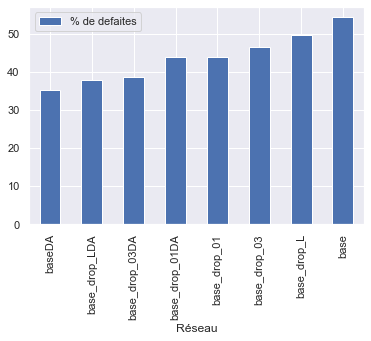

In [99]:
H03 = pd.DataFrame(np.array(Histo_quel_NN_NN_VS_NN_randStart)[:,2] , columns = ["Réseau"])
plt.figure(figsize=(12,8))
H03["% de defaites"] = 1
df_defaite_G1 = 100*pd.pivot_table(H03, index = ["Réseau"], values = ["% de defaites"], aggfunc = np.sum )/(len(Model_list)*2*n_game)
df_defaite_G1.sort_values(["% de defaites"]).plot.bar()

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text yticklabel objects>)

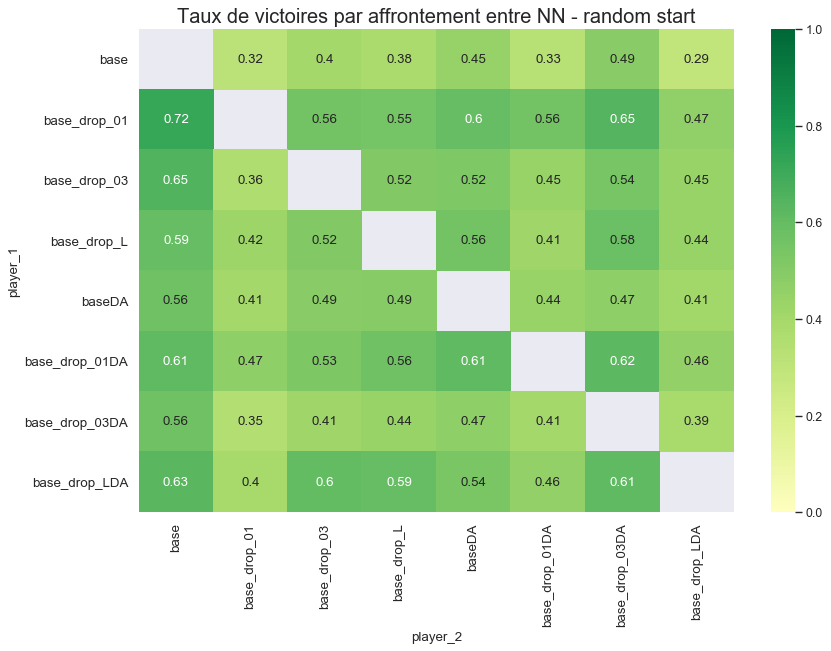

In [100]:
    df_result = pd.DataFrame(data= Histo_quel_NN_NN_VS_NN_randStart , columns = ["player_1","player_2","Looser" ] )
    df_result["P1_win"] = (df_result["player_2"] == df_result["Looser"]).astype("int16")
    df_result["P2_win"] = (df_result["player_1"] == df_result["Looser"]).astype("int16")
    df_result_game = pd.pivot_table(df_result, "P1_win" , "player_1" , "player_2")
    plt.figure(figsize=(12,8), dpi= 80)
    sns.heatmap(df_result_game, xticklabels=Name_list, yticklabels=Name_list, cmap='RdYlGn', center=0, annot=True,vmin=0, vmax=1)
    plt.title('Taux de victoires par affrontement entre NN - random start', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

**Interprétation des taux de victoire des NN avec début de parties aléatoires :**
- On constate dans le bar plat que les NN ne se distinguent pas particulièrement dans leur capacité à mieux jouer que les autres : les taux de défaites des NN sont compris entre 40% et 60%
- Idem pour le plot 2D des taux de victoires, aucun NN ne sort du lot et tous gagnent entre 35% et 65% de leurs matchs

Nous essayons maintenant de réentrainer les NN avec plus d’exemples issus des coups uniques joués lors de ces parties. 


In [101]:
GameFormated_NN_VS_NN_randStart = format_allGame(HistoWinner_NN_VS_NN_randStart) 
print(GameFormated_NN_VS_NN_randStart.shape) #(166414, 256)
np.unique(GameFormated_NN_VS_NN_randStart, axis = 0).shape #(145234, 256)

(165932, 256)


(144924, 256)

On constate que cette fois-ci, les historiques de parties joués avec les 2 premiers coups aléatoires sont des coups uniques à plus de 80%.

### Préparation des données pour re entraines les NN

On réentraine les NN avec les données suivantes:
- Les coups uniques des parties NN VS MC
- Les coups uniques des parties NN VS NN avec random start
- Les coups uniques des parties NN VS NN avec random start

On vérifiera aussi que coups que l'on rajoute ainsi au train ne sont pas déjà présent dans le test (pour ne pas fausser les scores)

In [102]:
train_gen2 = pd.DataFrame(train)
train_all = pd.concat([train_gen2,pd.DataFrame(GameFormated_MC100),pd.DataFrame(GameFormated_NN_VS_NN),pd.DataFrame(GameFormated_NN_VS_NN_randStart)])

In [103]:
print(train_all.shape)
train_all = train_all.drop_duplicates()
print(train_all.shape)

(379059, 256)
(165477, 256)


Le nouveau train issus des parties jouée et du CSV contient beaucoup plus de coups. On retire les coups qui seraient présent dans le train

In [104]:
train_all_np = np.array(train_all)
test_np = np.array(test)

aset = set([tuple(x) for x in train_all_np])
bset = set([tuple(x) for x in test_np])
intersect = [x for x in aset & bset]
print(np.array(intersect).shape)

(190, 256)


Effectivement on retrouve une centaine de coup du test dans le nouveaux coups générés pour le train, ils sont retirés

In [105]:
Train_G2 = []
for x in aset:
    if  not (x in intersect):
        Train_G2.append(x)
random.shuffle(Train_G2)

## Entrainement des NN sur les données enrichis des parties précédentes (Génération 2)

In [106]:
X_train_DA_NO_G2,Y_train_DA_NO_G2,X_test_DA_NO_G2,Y_test_DA_NO_G2 =  prepare_train_DA_NO(Train_G2,test)
X_train_DA_YES_G2,Y_train_DA_YES_G2,X_test_DA_YES_G2,Y_test_DA_YES_G2 =  prepare_train_DA_YES(Train_G2,test)

X_train_DA_NO_G2


array([[[[0., 1., 1.],
         [1., 0., 1.],
         [0., 1., 1.],
         ...,
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]],

        [[0., 1., 1.],
         [1., 0., 1.],
         [0., 1., 1.],
         ...,
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]],

        [[0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.],
         ...,
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]],

        ...,

        [[1., 0., 1.],
         [0., 1., 1.],
         [0., 1., 1.],
         ...,
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]],

        [[1., 0., 1.],
         [1., 0., 1.],
         [0., 1., 1.],
         ...,
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]],

        [[0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.],
         ...,
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]]],


       [[[1., 0., 1.],
         [1., 0., 1.],
         [1., 

In [107]:
X_train_DA_YES_G2.shape

(661148, 8, 8, 3)

In [82]:
list(set(X_train_DA_YES_G2)).shape

TypeError: unhashable type: 'numpy.ndarray'

['base_G2',
 'base_drop_01_G2',
 'base_drop_03_G2',
 'base_drop_L_G2',
 'baseDA_G2',
 'base_drop_01DA_G2',
 'base_drop_03DA_G2',
 'base_drop_LDA_G2']

In [108]:

Model_list_G2 = []
Name_list = ["base","base_drop_01","base_drop_03","base_drop_L","baseDA","base_drop_01DA","base_drop_03DA","base_drop_LDA" ]
Name_list_G2 = [N + '_G2' for N in Name_list]
Model_list_G2.append(get_model_base())
Model_list_G2.append(get_model_dropout_01())
Model_list_G2.append(get_model_dropout_03())
Model_list_G2.append(get_model_dropout_L())
Model_list_G2.append(get_model_base())
Model_list_G2.append(get_model_dropout_01())
Model_list_G2.append(get_model_dropout_03())
Model_list_G2.append(get_model_dropout_L())

Historique_all_G2 = []

Historique_all_G2.append(Keras_training(Model_list_G2[0],X_train_DA_NO_G2,Y_train_DA_NO_G2))
Historique_all_G2.append(Keras_training(Model_list_G2[1],X_train_DA_NO_G2,Y_train_DA_NO_G2))
Historique_all_G2.append(Keras_training(Model_list_G2[2],X_train_DA_NO_G2,Y_train_DA_NO_G2))
Historique_all_G2.append(Keras_training(Model_list_G2[3],X_train_DA_NO_G2,Y_train_DA_NO_G2))
#Historique_all_G2.append(Keras_training(Model_list_G2[4],X_train_DA_YES_G2,Y_train_DA_YES_G2))
#Historique_all_G2.append(Keras_training(Model_list_G2[5],X_train_DA_YES_G2,Y_train_DA_YES_G2))
#Historique_all_G2.append(Keras_training(Model_list_G2[6],X_train_DA_YES_G2,Y_train_DA_YES_G2))
#Historique_all_G2.append(Keras_training(Model_list_G2[7],X_train_DA_YES_G2,Y_train_DA_YES_G2))


Train on 148758 samples, validate on 16529 samples
Epoch 1/20
148758/148758 [==============================] - 17s 112us/step - loss: 1.8475 - acc: 0.4906 - val_loss: 1.5296 - val_acc: 0.5554
Epoch 2/20
148758/148758 [==============================] - 12s 82us/step - loss: 1.2509 - acc: 0.6193 - val_loss: 1.2935 - val_acc: 0.6074
Epoch 3/20
148758/148758 [==============================] - 12s 82us/step - loss: 1.1695 - acc: 0.6369 - val_loss: 1.2523 - val_acc: 0.6202
Epoch 4/20
148758/148758 [==============================] - 12s 82us/step - loss: 1.1154 - acc: 0.6493 - val_loss: 1.2956 - val_acc: 0.6030
Epoch 5/20
148758/148758 [==============================] - 12s 81us/step - loss: 1.0693 - acc: 0.6611 - val_loss: 1.2167 - val_acc: 0.6199
Epoch 6/20
148758/148758 [==============================] - 12s 82us/step - loss: 1.0268 - acc: 0.6723 - val_loss: 1.2246 - val_acc: 0.6226
Epoch 7/20
148758/148758 [==============================] - 12s 82us/step - loss: 0.9871 - acc: 0.6827 - val

In [109]:
Historique_all_G2x = Historique_all_G2[0:4]

In [110]:
#Historique_all_G2.append(Keras_training(Model_list_G2[4],X_train_DA_YES_G2,Y_train_DA_YES_G2))
#Historique_all_G2.append(Keras_training(Model_list_G2[5],X_train_DA_YES_G2,Y_train_DA_YES_G2))
Historique_all_G2.append(Keras_training(Model_list_G2[6],X_train_DA_YES_G2,Y_train_DA_YES_G2))
Historique_all_G2.append(Keras_training(Model_list_G2[7],X_train_DA_YES_G2,Y_train_DA_YES_G2))

Train on 595033 samples, validate on 66115 samples
Epoch 1/20
595033/595033 [==============================] - 60s 101us/step - loss: 2.4854 - acc: 0.2978 - val_loss: 2.0431 - val_acc: 0.3770
Epoch 2/20
595033/595033 [==============================] - 56s 94us/step - loss: 2.0985 - acc: 0.3657 - val_loss: 1.9648 - val_acc: 0.3909
Epoch 3/20
595033/595033 [==============================] - 56s 95us/step - loss: 2.0565 - acc: 0.3743 - val_loss: 1.9394 - val_acc: 0.3962
Epoch 4/20
595033/595033 [==============================] - 57s 96us/step - loss: 2.0376 - acc: 0.3794 - val_loss: 1.9347 - val_acc: 0.3978
Epoch 5/20
595033/595033 [==============================] - 57s 96us/step - loss: 2.0292 - acc: 0.3816 - val_loss: 1.9160 - val_acc: 0.3995
Epoch 6/20
595033/595033 [==============================] - 57s 96us/step - loss: 2.0225 - acc: 0.3831 - val_loss: 1.9061 - val_acc: 0.3992
Epoch 7/20
595033/595033 [==============================] - 58s 97us/step - loss: 2.0178 - acc: 0.3843 - val

In [111]:
Historique_all_G2.append(Keras_training(Model_list_G2[4],X_train_DA_YES_G2,Y_train_DA_YES_G2))
Historique_all_G2.append(Keras_training(Model_list_G2[5],X_train_DA_YES_G2,Y_train_DA_YES_G2))

Train on 595033 samples, validate on 66115 samples
Epoch 1/20
595033/595033 [==============================] - 57s 95us/step - loss: 2.2221 - acc: 0.3451 - val_loss: 1.9696 - val_acc: 0.3908
Epoch 2/20
595033/595033 [==============================] - 52s 87us/step - loss: 1.8858 - acc: 0.4086 - val_loss: 1.8795 - val_acc: 0.4075
Epoch 3/20
595033/595033 [==============================] - 52s 87us/step - loss: 1.8239 - acc: 0.4244 - val_loss: 1.8674 - val_acc: 0.4121
Epoch 4/20
595033/595033 [==============================] - 52s 87us/step - loss: 1.7857 - acc: 0.4355 - val_loss: 1.8471 - val_acc: 0.4165
Epoch 5/20
595033/595033 [==============================] - 52s 88us/step - loss: 1.7589 - acc: 0.4427 - val_loss: 1.8377 - val_acc: 0.4215
Epoch 6/20
595033/595033 [==============================] - 52s 87us/step - loss: 1.7367 - acc: 0.4492 - val_loss: 1.8349 - val_acc: 0.4218
Epoch 7/20
595033/595033 [==============================] - 52s 87us/step - loss: 1.7192 - acc: 0.4544 - val_

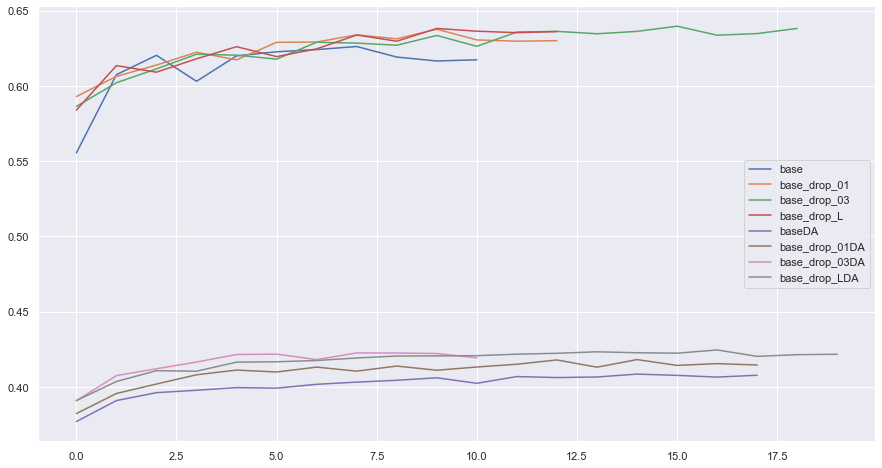

In [112]:
plt.figure(figsize=(15,8))
for i in np.arange(0,len(Historique_all_G2)):
    plt.plot(np.arange(0,len(Historique_all_G2[i].history["val_acc"])), Historique_all_G2[i].history["val_acc"])
    
plt.legend(np.array(Name_list))

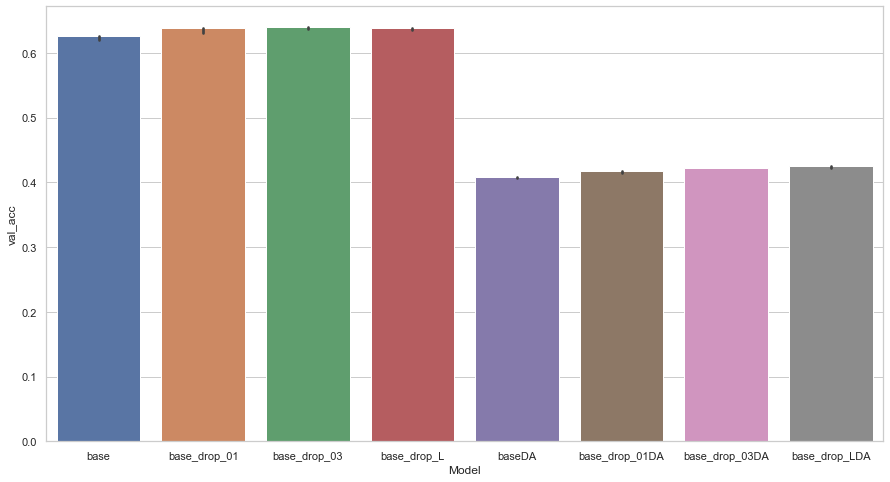

In [113]:
for i in np.arange(0,7):
    if i == 0:
        df_data = pd.DataFrame(data = Historique_all_G2[i].history)
        df_data["Model"] = Name_list[i]
    else:
        df_datatmp = pd.DataFrame(data = Historique_all_G2[i].history)
        df_datatmp["Model"] = Name_list[i]
        df_data = pd.concat([df_data,df_datatmp])
        
for i in np.arange(0,len(Historique_all_G2)):
    if i == 0:
        df_data = pd.DataFrame(data = Historique_all_G2[i].history)
        df_data["Model"] = Name_list[i]
    else:
        df_datatmp = pd.DataFrame(data = Historique_all_G2[i].history)
        df_datatmp["Model"] = Name_list[i]
        df_data = pd.concat([df_data,df_datatmp])

sns.set(style="whitegrid")
plt.figure(figsize=(15,8))
sns.barplot(x="Model", y="val_acc", data=df_data , estimator= max)

**Commentaires:**
- L'accuracy sur le jeu de test est plus importante pour les NN entrainées dans DA avec en moyenne 60% contre 40% pour les NN avec DA.
- Par rapport aux NN entrainés précédemment se représente une amélioration pour les NN sans DA et une baisse de performance pour les modèles avec DA. Cela vient probablement du fait que le jeu de test n'a pas été augmenté et donc les prédictions des NN sont meilleures quand ils sont entrainés sur les NN sans DA, notamment maintenant que l'on a beaucoup augmenté la taille des données d'entrainement d'une autre façon (en reprenant les historiques des parties gagnantes).

Il sera néanmoins intéressant de regarder comment les NN performent dans les matches et si la baisse d’accurracy se traduit par un NN jouant moins bien.

### Matchs entre les réseaux
**Match : NN de la première génération VS 2e génération (G1 VS G2)**

In [114]:
#G1 VS G2
n_game = 200
Loser_badmove_NN_VS_NN_G1_VS_G2_randStart = []
HistoWinner_NN_VS_NN_G1_VS_G2_randStart = []
Histo_quel_NN_NN_VS_NN_G1_VS_G2_randStart = []

for m0 in np.arange(0,len(Model_list_G2)):
    for m1 in np.arange(0,len(Model_list)):
        for i in np.arange(0,n_game):
            if True:
                damier = np.zeros((8, 8)) 
                play = random.choice(coups_possibles_H(damier)) #coup random
                coup_H(damier, play[0], play[1])
                play = random.choice(coups_possibles_V(damier)) #coup random
                coup_V(damier, play[0], play[1])            
                player = randint(1,2)
                sens = randint(0,1)
                if sens == 0:
                    a,b = (Name_list_G2[m0]),(Name_list[m1])
                    x,y =  NN_VS_NN(damier, player, Model_list[m0] , Model_list_G2[m1],a,b)
                else:
                    b,a = (Name_list_G2[m1]),(Name_list[m0])
                    x,y = NN_VS_NN(damier, player, Model_list_G2[m1] , Model_list[m0],b,a)
                Loser_badmove_NN_VS_NN_G1_VS_G2_randStart.append(x)
                HistoWinner_NN_VS_NN_G1_VS_G2_randStart.append(y)
                Histo_quel_NN_NN_VS_NN_G1_VS_G2_randStart.append((a,b,x[0]))
    print(m0, "/",len(Model_list)-1)


0 / 7
1 / 7
2 / 7
3 / 7
4 / 7
5 / 7
6 / 7
7 / 7


<Figure size 864x576 with 0 Axes>

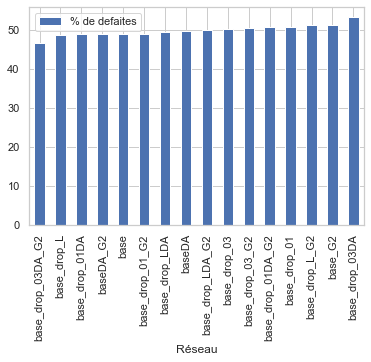

In [142]:
H03 = pd.DataFrame(np.array(Histo_quel_NN_NN_VS_NN_G1_VS_G2_randStart)[:,2] , columns = ["Réseau"])
plt.figure(figsize=(12,8))
H03["% de defaites"] = 1
df_defaite_G1 = 100*pd.pivot_table(H03, index = ["Réseau"], values = ["% de defaites"], aggfunc = np.sum )/(len(Model_list)*n_game)
df_defaite_G1.sort_values(["% de defaites"]).plot.bar()

Lorsque l’on fait jouer les NN de la 2e génération, nous constatons que les taux de défaites sont tous relativement proches de 50%. Ainsi aucun des réseaux ne se démarque vraiment dans sa capacité à battre les autres et c’est surtout les conditions de départ du damier (initialisation avec 2coups aléatoire) qui déterminent le gagnant.

### Faire jouer la 2eme generation contre elle meme

In [129]:
#G1 VS G2
n_game = 200
Loser_badmove_NN_VS_NN_G2_VS_G2_randStart = []
HistoWinner_NN_VS_NN_G2_VS_G2_randStart = []
Histo_quel_NN_NN_VS_NN_G2_VS_G2_randStart = []

for m0 in np.arange(0,len(Model_list_G2)):
    for m1 in np.arange(0,len(Model_list_G2)):
        for i in np.arange(0,n_game):
            if m0 != m1:
                damier = np.zeros((8, 8)) 
                play = random.choice(coups_possibles_H(damier)) #coup random
                coup_H(damier, play[0], play[1])
                play = random.choice(coups_possibles_V(damier)) #coup random
                coup_V(damier, play[0], play[1])            
                player = randint(1,2)
                sens = randint(0,1)
                if sens == 0:
                    a,b = (Name_list_G2[m0]),(Name_list_G2[m1])
                    x,y =  NN_VS_NN(damier, player, Model_list_G2[m0] , Model_list_G2[m1],a,b)
                else:
                    b,a = (Name_list_G2[m1]),(Name_list_G2[m0])
                    x,y = NN_VS_NN(damier, player, Model_list_G2[m1] , Model_list_G2[m0],b,a)
                Loser_badmove_NN_VS_NN_G2_VS_G2_randStart.append(x)
                HistoWinner_NN_VS_NN_G2_VS_G2_randStart.append(y)
                Histo_quel_NN_NN_VS_NN_G2_VS_G2_randStart.append((a,b,x[0]))
    print(m0, "/",len(Model_list)-1)


0 / 7
1 / 7
2 / 7
3 / 7
4 / 7
5 / 7
6 / 7
7 / 7


<Figure size 864x576 with 0 Axes>

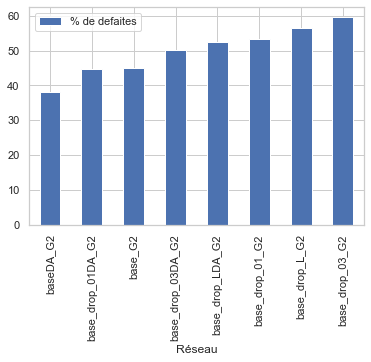

In [143]:
H03 = pd.DataFrame(np.array(Histo_quel_NN_NN_VS_NN_G2_VS_G2_randStart)[:,2] , columns = ["Réseau"])
plt.figure(figsize=(12,8))
H03["% de defaites"] = 1
df_defaite_G1 = 100*pd.pivot_table(H03, index = ["Réseau"], values = ["% de defaites"], aggfunc = np.sum )/((len(Model_list_G2)-1)*2*n_game)
df_defaite_G1.sort_values(["% de defaites"]).plot.bar()

Le modèle de base avec Data Augmentation de la génération a le taux de défaites le plus faible. Cependant ce modèle à une Val_Acc d’environ 0.4 qui est bien inférieur à celle des modèles de la G2 sans DA qui sont autour de 0.6.
Ainsi l’entrainement du réseau sur le jeu de données augmenté, même s’il fait baisser l’accuracy du modèle, cela produit un NN qui semble mieux réussir à battre les autres.


### Conclusion

Nous avons pu apprendre à un réseau à jouer aux dominos grâce à un historique de coups "intelligents" fournis dans les données d'entrainement.
Ces données étaient elle-même tirés de simulation de Monte-Carlo dont le fonctionnement pour choisir le meilleur coup est une approche brute force consistant à tester pleins de combinaisons de coups et choisir ceux qui ont le plus de probabilités de mener à une victoire.

Nous avons pu constater que les NN arrivent rapidement à apprendre à jouer ces coups et à battre un bot Monte-Carlo. Cependant en termes de Val_Acc sur les données de test, la première génération ne fait pas mieux que 50%. Ce chiffre reste cependant plutôt bon, car les possibilités de coup à jours sur chaque damier sont relativement conséquentes (surtout en début de partie).

Nous avons ensuite fait jouer les NN contre eux-mêmes afin de voir si les valeurs de Val_acc étaient liées à une capacité à "mieux jouer" et également comment la structure du réseau influence la façon de jouer.
Nous n'avons pas constaté de relation notable entre la Val_Acc et les chances de gagner contre les autres réseaux, au contraire, certains NN avec des Val_Acc plus faibles sont plus fortes que ceux avec des Val_Acc 50% plus grandes.

Finalement, nous avons enregistré les coups gagnants des parties pour enrichir le jeu de données fourni à la base et réentraîner les réseaux. Cela à effectives permis de gagner en Val_Acc et de passer de 0.5 à 0.65 pour les meilleurs modèles.

Bien que cette façon d'enrichir les données ait pu augmenter le score de Val_Acc, cela ne semble pas vraiment rentre le NN "plus fort" pour gagner les parties. En effet même si tous les coups que nous avons rajoutés sont issus de coups joués par les NN ayant gagné leur partie, tous ne sont peut-être pas les plus "intelligents" à jouer.

Pour aller plus loin:
- nous aurions pu regarder le nombre de dominos d'avance des gagnants et ne retenir que les parties avec le plus d'avance, et donc surement des coups plus optimisés.
- Également nous aurions pu implémenter du grid search sur les hyperparametres du réseau, notamment les drop_out ou le batch size

